<div align="center">

## 🦾🤖 **Proyecto Final : Entrenamiento de redes neuronales con algoritmos genéticos ​** 📟🧪

----
## **Integrantes del equipo:**

### <br> <img src="https://media.tenor.com/m6cM9lV-doYAAAAi/batman-batman-beyond.gif" width="30"> **Carlos Emilio Castañon Maldonado** & **Dana Berenice Hérnandez Norberto** <img src="https://i.pinimg.com/originals/c2/00/92/c2009226c462e1fe82a19ca7cd206d1c.gif" width="30"> <br> 

</div>


Para la presente usaremos como  base el artículo *Training  Feedforward  Neural  Networks  Using  Genetic  Algorithms* 

https://www.ijcai.org/Proceedings/89-1/Papers/122.pdf .


En lugar de la base de datos que se usa en el artículo tomarémos un conjunto de datos de todas las posibles
combinaciones de ganar o perder en el juego del gato (tic-tac-toe) en un tablero de 3x3.

https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame


Los datos se componen de las columnas (0-0),(0-1),(0-2),(1-0),(1-1),(1-2),(2-0),(2-1),(2-2) y result


```C
.................     .................
(0-0)|(0-1)|(0-2)       x  |  b  |  b  
.................     .................
(1-0)|(1-1)|(1-2)       b  |  b  |  b  
.................     .................
(2-0)|(2-1)|(2-2)       b  |  b  |  o  
.................     .................

```

En donde cada columna representa la posición en el tablero y su contenido representa si en esa casilla hay una "x", una "o" o está vacía ("b").
Los datos codificados de lo anterior nos da un resultado de 958 posibles combinaciones de ganar o perder en el juego del gato, en el data set el ganar
esta codificado como "positive" y el perder como "negative".

El objetivo de este Proyecto Final es el de poder entrenar y optimizar una red neuronal mediante el uso de algoritmos genéticos para que esta pueda jugar contra
un jugador humano en el juego del gato (tic-tac-toe) en un tablero de 3x3.


<div align="center">

[![](https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWkwYml2cDgyOXQ4c2N5d3B0eHR4bXpoN3VhMm5hZGg1a3UwbDRqdCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/gR92EF4p9XyEHyD2n5/giphy.gif)](https://youtu.be/ABzh6hTYpb8?t=3)

</div>



In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

In [2]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
#Definimos el dispositivo que se usara.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
#device = "cpu"

Device:  cuda


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import sklearn as sk

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [4]:
class Gen_net(nn.Module):
    '''
    Definimos un modelo de red neuronal sobre el cual podamos
    evaluar el algoritmo genetico.
    '''
    def __init__(self, in_features, hidden_1, hidden_2, out_features):
        '''
        La estructura de la red como se define en el articulo.
        Dado que no usamos el mismo conjunto de datos
        los valores de in_features y out_features se veran afectados.
        '''
        super(Gen_net, self).__init__()
        self.layer1 = nn.Linear(in_features, hidden_1)
        self.layer2 = nn.Linear(hidden_1, hidden_2)
        self.layer3 = nn.Linear(hidden_2, out_features)
        self.sigmoid = nn.Sigmoid()

        # Calculamos el numero total de pesos en la red
        self.total_weights = self.count_weights()

    def count_weights(self):
        '''
        Calcula el numero total de pesos en la red.
        '''
        total = 0
        for param in self.parameters():
            total += param.numel()
        return total

    def forward(self, X):
        '''
        Definimos la pasada hacia adelante de la red (forward).
        '''
        X = X.to(self.layer1.weight.device)  # Con esto aseguramos que X este en el mismo dispositivo que los pesos de la primera capa
        X = self.layer1(X)
        X = self.sigmoid(X)
        X = self.layer2(X)
        X = self.sigmoid(X)
        X = self.layer3(X.float())  
        return X


    def build_from_chromosome(self, chromosome):
        '''
        Definimos una funcion para que a partir de un cromosoma modifique los
        pesos de la red.
        '''
        with torch.no_grad():
            # Extraemos pesos
            w1 = torch.tensor(chromosome[:self.layer1.weight.numel()]).reshape(self.layer1.weight.shape).float()
            w2 = torch.tensor(chromosome[self.layer1.weight.numel():self.layer1.weight.numel() + self.layer2.weight.numel()]).reshape(self.layer2.weight.shape).float()
            w3 = torch.tensor(chromosome[-self.layer3.weight.numel():]).reshape(self.layer3.weight.shape).float()

            # Actualizamos pesos
            self.layer1.weight.data = w1
            self.layer2.weight.data = w2
            self.layer3.weight.data = w3


    def training(self, X, Y, optimizer):
        '''
        Definimos una funcion de entrenamiento utilizando la misma
        funcion de error que se usa para obtener el fitness de la red.
        '''
        criterion = nn.MSELoss()
        optimizer.zero_grad()
        output = self(X)
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()
        return loss.item()




In [20]:
def mostrarMatrizDatos():
    print("-----------------")
    print("(0-0)|(0-1)|(0-2)")
    print("-----------------")
    print("(1-0)|(1-1)|(1-2)")
    print("-----------------")
    print("(2-0)|(2-1)|(2-2)")
    print("-----------------")

# Leemos el conjunto de datos
dataVis = pd.read_csv('./tic+tac+toe+endgame/tic-tac-toe.data')
dataFrameVis = pd.DataFrame(dataVis)

# Mostramos los datos
dataFrameVis

,(0-0),(0-1),(0-2),(1-0),(1-1),(1-2),(2-0),(2-1),(2-2),result
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


In [21]:
mostrarMatrizDatos()

-----------------
(0-0)|(0-1)|(0-2)
-----------------
(1-0)|(1-1)|(1-2)
-----------------
(2-0)|(2-1)|(2-2)
-----------------


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split


path = './tic+tac+toe+endgame/tic-tac-toe.data'


def read_data(path):
    '''
    Definimos una funcion para leer los datos y obtener su formato correcto.

    Los datos son del juego de gato, donde las columnas representan las posiciones del tablero
    y la ultima columna es la etiqueta de si el jugador gano o perdio.

    La etiqueta es un string en un tablero (matriz 3x3) que representa el estado del juego

    (0-0)|(0-1)|(0-2)
    -----------------
    (1-0)|(1-1)|(1-2)
    -----------------
    (2-0)|(2-1)|(2-2)
    -----------------

    Los valores de las celdas pueden ser 'x', 'o' o 'b' (blank)
    '''
    # Leer el archivo data
    data = pd.read_csv(path, sep=',')

    # Normalizar los datos
    data = data.replace('x', 1)
    data = data.replace('o', 2)
    data = data.replace('b', 0)
    data = data.replace('positive', 9)
    data = data.replace('negative', 6)

    # Aplicar la codificación one-hot a las columnas del tablero
    for column in data.columns[:-1]:  # Excluimos la última columna porque es la etiqueta
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)  # Eliminamos la columna original



    # Dividimos los datos en características (X) y etiquetas (Y)
    X = data.iloc[:, :-1]
    Y = data.iloc[:, -1]

    # Aleatorizamos los datos
    X = X.sample(frac=1).reset_index(drop=True)
    Y = Y.sample(frac=1).reset_index(drop=True)

    # Dividimos los datos
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

    return X_train, X_val, Y_train, Y_val

def confusion(model, X, Y):
    '''
    Definimos una funcion de confusion para evaluar el modelo.
    '''
    # Evaluar el modelo en el conjunto de datos de entrada
    Y_pred = model.predict(X)

    # Calcular la matriz de confusion
    confusion_matrix = pd.crosstab(pd.Series(Y, name='Actual'), pd.Series(Y_pred, name='Predicted'))

    return confusion_matrix


In [6]:
class Gen_train():
    '''
    Definimos la estructura del algortimo genetico
    '''
    def __init__(self, model, parent_scalar, operator_probabilities, population_size):
        '''
        Definimos las propiedades del algortimo como se describe en el articulo.
        En la presente usamos el parametro model para tener un ejemplar de la red 
        sobre la cual podamos realizar las operaciones necesarias.
        Incializamos la poblacion utilizando una distribucion t
        '''
        self.model = model
        self.parent_scalar = parent_scalar
        self.operator_probabilities = operator_probabilities
        self.population_size = population_size
        self.population = []
        self.initialize_population()
        self.losses = []

    def initialize_population(self):
        '''
        Inicializamos la poblacion utilizando una distribucion t
        '''
        # Poblacion inicial para una distribucion t
        for _ in range(self.population_size):
            chromosome = np.random.standard_t(df=1, size=self.model.total_weights)
            self.population.append(chromosome)

    def get_weights(self, element):
        '''
        Funcion para obtener las matrices de pesos a partir de un elemento de la poblacion.
        Debe tener las mismas dimenciones que los pesos para la red.
        '''
        return element


    def set_chromosome(self, w1, w2, w3, element):
        '''
        Funcion para actualizar un elemento de la poblacion a partir de los pesos que determinan
        a una red. Se actualizara el ejemplar de la poblacion que se encuentre en la posicion
        element.
        '''
        self.population[element] = np.concatenate((w1.flatten(), w2.flatten(), w3.flatten()))


    def fitness(self, X, Y, element):
        '''
        Funcion para determinar la adecuacion de un elemento de la poblacion.
        En este caso, la adecuacion nos servira para determinar los elementos
        mas aptos. Para esta implementacion se considerara que una adecuacion
        menor sera de un menor individuo, por lo que tendra mayores
        probabilidades de reproducirse.
        '''
        chromosome = self.population[element]
        self.model.build_from_chromosome(chromosome)

        X_tensor = torch.from_numpy(X.values.astype(np.float32))
        Y_tensor = torch.from_numpy(Y.values.astype(np.float32))

        # Evaluamos el fitness usando el error cuadratico medio
        outputs = self.model(X_tensor)
        loss = nn.MSELoss()(outputs, Y_tensor)
        return loss.item()



    ## Definimos las operaciones que se usan en el experimento numero 5 del articulo.
    ## Todas las definiciones de los operadores se encuentran en la seccion 5 del articulo.

    def train(self, steps):
        '''
        Definimos la funcion de entrenamiento, la cual realizara el numero de pasos
        seleccionados. Para ello usamos la variable de parent_scalar para determinar la probabilidad
        de que un individuo de la poblacion sea remplazado en cada iteracion. 
        Esta funcion muestra una grafica del error al finalizar el entrenamiento. 
        Y regresa una red con los pesos del individuo con mejor fitness al finalizar el entrenamiento.
        '''
        # Definimos el conjunto de datos
        X_train, X_val, Y_train, Y_val = read_data(path)

        # Inicializamos el mejor modelo y su fitness
        best_model = None
        best_fitness = np.inf
        losses = []
        for step in range(steps):
            # Evaluamos la adecuacion de cada individuo en la poblacion
            fitness_scores = [self.fitness(X_train, Y_train, i) for i in range(self.population_size)]
            best_individual_index = np.argmin(fitness_scores)
            current_best_fitness = fitness_scores[best_individual_index]

            # Almacenamos el mejor modelo hasta el momento
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                best_model = self.model

            # Mostramos el progreso cada 100 pasos en pantalla
            if step % 100 == 0:
                print(f"Step: {step}, Best fitness: {best_fitness}")

            # Seleccionar los padres (los mejores individuos de la poblacion)
            parents_indices = np.argsort(fitness_scores)[:int(self.parent_scalar * self.population_size)]

            # Generamos la nueva generacion utilizando los operadores geneticos
            new_population = []
            for _ in range(self.population_size):
                parent1, parent2 = np.random.choice(parents_indices, size=2, replace=False)
                child = self.crossover(self.population[parent1], self.population[parent2])
                child = self.mutate(child)
                new_population.append(child)

            # Actualizamos la poblacion
            self.population = new_population

            # Registramos la perdida
            losses.append(best_fitness)

        # Mostramos la curva de aprendizaje
        plt.plot(losses)
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        plt.title('Training Curve (Genetic Algorithm)')
        plt.show()

        return best_model

    def crossover(self, parent1, parent2):
        '''
        La operacion de cruce como se describe en el articulo.
        '''
        child = np.zeros_like(parent1)
        for i in range(len(parent1)):
            if np.random.rand() < 0.5:
                child[i] = parent1[i]
            else:
                child[i] = parent2[i]
        return child

    def mutate(self, chromosome):
        '''
        La operacion de mutacion como se describe en el articulo.
        '''
        for i in range(len(chromosome)):
            if np.random.rand() < self.operator_probabilities['mutation']:
                chromosome[i] = np.random.standard_t(df=1)
        return chromosome

    def confusion(self, X, Y):
        '''
        La funcion de confusion para evaluar el modelo.
        '''
        # Convertir los datos a tensores
        X_tensor = torch.from_numpy(X.values.astype(np.float32))
        Y_tensor = torch.from_numpy(Y.values.astype(np.float32))

        # Predecir las etiquetas de los datos de entrada
        outputs = self.model(X_tensor)
        _, predicted = torch.max(outputs.data, 1)

        # Calcular la matriz de confusión
        cm = confusion_matrix(Y_tensor.numpy(), predicted.numpy())

        return cm


Compara la eficacia del algoritmo genético y comparalo con backpropagation, mostrando las gráficas de sus entrenamientos. Y compara sus matrices de confusión. Usa la misma cantidad de capas ocultas con la misma cantidad de neuronas que en el artículo, pero modifica tanto los elementos de entrada como los de salida.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([766])) that is different to the input size (torch.Size([766, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Step: 0, Best fitness: 0.43987157940864563
Step: 100, Best fitness: 0.2396305948495865
Step: 200, Best fitness: 0.2310982644557953
Step: 300, Best fitness: 0.2310982644557953
Step: 400, Best fitness: 0.2310982644557953
Step: 500, Best fitness: 0.2310982644557953
Step: 600, Best fitness: 0.2310982644557953
Step: 700, Best fitness: 0.2310982644557953
Step: 800, Best fitness: 0.2310982644557953
Step: 900, Best fitness: 0.2310982644557953
Step: 1000, Best fitness: 0.2310982644557953
Step: 1100, Best fitness: 0.2310982644557953
Step: 1200, Best fitness: 0.2310982644557953
Step: 1300, Best fitness: 0.2310982644557953
Step: 1400, Best fitness: 0.2310982644557953
Step: 1500, Best fitness: 0.2310982644557953
Step: 1600, Best fitness: 0.2310982644557953
Step: 1700, Best fitness: 0.2310982644557953
Step: 1800, Best fitness: 0.2310982644557953
Step: 1900, Best fitness: 0.23039191961288452
Step: 2000, Best fitness: 0.23039191961288452
Step: 2100, Best fitness: 0.23039191961288452
Step: 2200, Best f

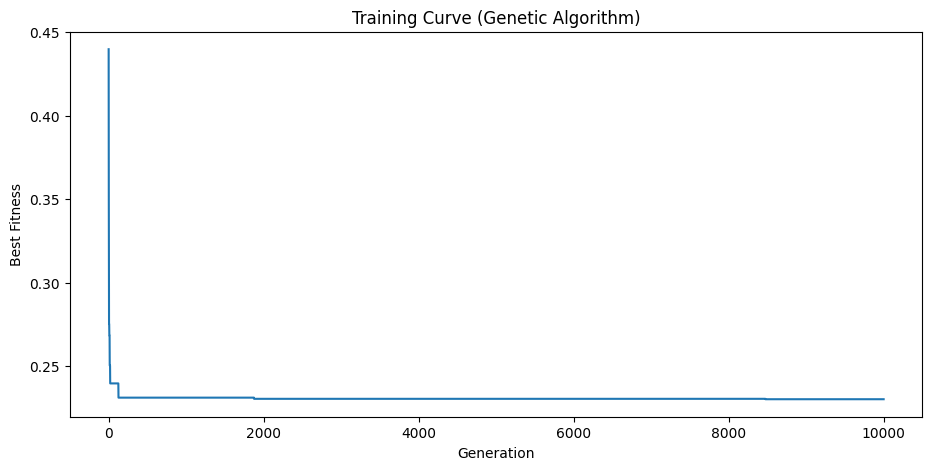

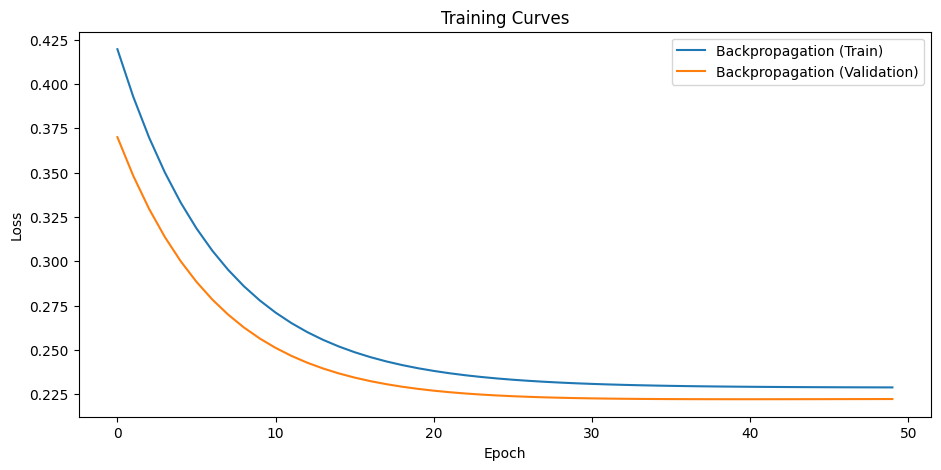

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# Definimos la arquitectura de la red neuronal
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()


    def forward(self, X):
        X = self.sigmoid(self.layer1(X))
        X = self.sigmoid(self.layer2(X))
        X = self.layer3(X)
        return X

    def predict(self, X):
        with torch.no_grad():
            pred = self.forward(torch.tensor(X))  # Convierte X a un tensor de PyTorch
        return pred.numpy().flatten().round().astype(int)


# Entrenamiento con backpropagation
def train_with_backpropagation(X_train, Y_train, X_val, Y_val, input_size, hidden_size1, hidden_size2, output_size, epochs):
    model = NeuralNet(input_size, hidden_size1, hidden_size2, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train.values.astype(np.float32)))  # Convertimos el DataFrame a un numpy array y luego a un tensor de PyTorch
        loss = criterion(outputs.view(-1), torch.tensor(Y_train.values.astype(np.float32)))  # Aplanamos los tensores
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Calculamos la perdida en el conjunto de validacion
        with torch.no_grad():
            val_outputs = model(torch.tensor(X_val.values.astype(np.float32)))  # Convertimos el DataFrame a un numpy array y luego a un tensor de PyTorch
            val_loss = criterion(val_outputs.view(-1), torch.tensor(Y_val.values.astype(np.float32)))  # Aplanamos los tensores
            val_losses.append(val_loss.item())

    return model, train_losses, val_losses




# Preparamos los datos
X_train, X_val, Y_train, Y_val = read_data('./tic+tac+toe+endgame/tic-tac-toe.data')

# Definicion de la arquitectura de la red neuronal
input_size = X_train.shape[1]
hidden_size1 = 10
hidden_size2 = 10
output_size = 1

# Entrenamiento con backpropagation
backprop_model, backprop_train_losses, backprop_val_losses = train_with_backpropagation(X_train, Y_train, X_val, Y_val, input_size, hidden_size1, hidden_size2, output_size, epochs=50)

# Entrenamiento con algoritmo genetico
gen_model = Gen_net(input_size, hidden_size1, hidden_size2, output_size)
genetic_algorithm = Gen_train(gen_model, parent_scalar=0.4, operator_probabilities={'crossover': 0.7, 'mutation': 0.4}, population_size=410)
genetic_model = genetic_algorithm.train(steps=10000)

# Graficas de las curvas de aprendizaje
plt.plot(backprop_train_losses, label='Backpropagation (Train)')
plt.plot(backprop_val_losses, label='Backpropagation (Validation)')
#plt.plot(genetic_algorithm.losses, label='Genetic Algorithm')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curves')
plt.legend()
plt.show()

# Guardamos el modelo del algoritmo genetico
torch.save(genetic_model, 'genetic_model.pth')

In [11]:
# Usamos al modelo para jugar tic-tac-toe con el modelo entrenado

# Cargamos el modelo
model = torch.load('genetic_model.pth')
model.eval()


# Función para tomar una decisión basada en el estado del tablero
def make_decision(board):
    # Convertir el tablero a una lista de números
    board_numeric = [1 if cell == 'x' else (2 if cell == 'o' else 0) for cell in board]
    # Convertir el tablero numérico en un tensor
    board_tensor = torch.tensor(board_numeric, dtype=torch.float32)

    # Definir las dimensiones del modelo
    input_size = board_tensor.shape[0]
    hidden_size1 = 40
    hidden_size2 = 40
    output_size = 1

    # Crear una nueva instancia del modelo
    model = Gen_net(input_size, hidden_size1, hidden_size2, output_size)

    # Pasar el tablero a través del modelo
    output = model(board_tensor.view(1, -1))  

    # Obtenemos la lista de las casillas vacías
    empty_cells = [i for i, cell in enumerate(board) if cell == ' ']

    # decision = torch.argmax(output).item()
    # Tomar la decisión basada en la salida del modelo
    # En caso de que esa casilla no forme parte de las casillas vacías, se toma la primera casilla vacía
    # Que el modelo haya decidido usar
    decision = empty_cells[output.argmax().item()] if output.argmax().item() in empty_cells else empty_cells[0]
    

    return decision



# Función para representar el tablero
def print_board(board):
    for i in range(3):
        print(' | '.join(board[i*3:(i+1)*3]))
        if i < 2:
            print('---------')

# Función para determinar si alguien ganó
def check_winner(board):
    # Revisamos las filas
    for i in range(3):
        if board[i*3] == board[i*3 + 1] == board[i*3 + 2] != ' ':
            return board[i*3]
    # Revisamos las columnas
    for i in range(3):
        if board[i] == board[i + 3] == board[i + 6] != ' ':
            return board[i]
    # Revisamos las diagonales
    if board[0] == board[4] == board[8] != ' ':
        return board[0]
    if board[2] == board[4] == board[6] != ' ':
        return board[2]
    return ' '

# Función para jugar
def play_game():
    # Inicializar el tablero
    board = [' ']*9
    # Inicializar el jugador
    player = 'x'
    # Jugar hasta que alguien gane o haya un empate
    while ' ' in board:
        print_board(board)
        print()
        # Si es el turno del jugador
        if player == 'x':
            # Pedir la posición al jugador
            position = int(input('Ingresa una posicion entre (0-8): '))
            # Si la posición está vacía
            if board[position] == ' ':
                # Colocar la marca
                board[position] = player
                # Revisar si alguien ganó
                winner = check_winner(board)
                if winner != ' ':
                    print_board(board)
                    print(f'{winner} Gano!')
                    return
                # Cambiar de jugador
                player = 'o'
        # Si es el turno de la computadora
        else:
            # Tomar la decisión de la computadora
            position = make_decision(board)
            # Colocar la marca
            board[position] = player
            # Revisar si alguien ganó
            winner = check_winner(board)
            if winner != ' ':
                print_board(board)
                print(f'{winner} Gano!')
                return
            # Cambiar de jugador
            player = 'x'
    # Si no hay ganador, es un empate
    print_board(board)
    print('Tenemos un empate!')

# Jugar
play_game()


  |   |  
---------
  |   |  
---------
  |   |  



  |   |  
---------
  |   |  
---------
  |   | x

o |   |  
---------
  |   |  
---------
  |   | x

o |   |  
---------
  |   |  
---------
  | x | x

o | o |  
---------
  |   |  
---------
  | x | x

o | o | x
---------
  |   |  
---------
  | x | x

o | o | x
---------
o |   |  
---------
  | x | x

o | o | x
---------
o |   | x
---------
  | x | x
x Gano!


In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()